<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : NVDA

This page does following:

- Libraries and trained model from previous step are loaded

- Defined customized functions as well as loss function

- Data are pulled, indicators are applied and prediction is made

<b>Import libraries and customized loss function and define customized function</b>

Bellow code defines customized function that are processing loaded data from stock market and makes prediction. Dataframe is normalized and reverted back via following formulas

<i>Linear scaling formula: x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
<i>Reverse linear scaling: x = (x * (maxv-minv)) + minv</i>

In [1]:
#Libraries
import tensorflow as tf
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Customized loss function
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

#Customized functions
def norm_df(pred1):
    df_temp = pd.DataFrame()
    try:
        pred1 = pred1.drop('Date',axis=1)
    except:
        pass
    pred_np = pred1.to_numpy()
    maxv = np.max(pred_np)
    minv = np.min(pred_np)
    df_temp = (pred1.iloc[:,:]-minv)/(maxv-minv)
    
    return df_temp, maxv,minv
def revert_df(df,maxv,minv):
    df_temp = pd.DataFrame() 
    df_temp = (df.iloc[:,:]*(maxv-minv))+minv
    
    return df_temp
def revert_prediction(value,maxv,minv):
    
    return (value * (maxv-minv))+minv

def MakePred(series,model):
    pr = series.to_numpy()
    series2=np.array([[pr]])   
    pred = tf.data.Dataset.from_tensor_slices(series2)
    prediction = model.predict(pred)
        
    return prediction
    
def Predict(pred):
    df_temp1, maxv, minv = norm_df(pred)
    pr = MakePred(df_temp1,model)
    print('prediction is: ',pr)
    prediction = revert_prediction(pr,maxv,minv)
    prediction = np.squeeze(prediction)
    
    #print("Prediction is: ",prediction)
    return prediction

def Profit_calculation(budget, entry, prediction):
    qty = round(budget / entry,0)
    return (prediction - entry) * qty 


<b>Load trained model</b>

In [2]:
#model = tf.keras.models.load_model('nvda_80_model_checkpoint_shuffled.h5', custom_objects={'sign_penalty': sign_penalty} )
#model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
model = tf.keras.models.load_model('nvda_80_model_checkpoint_recent.h5', custom_objects={'sign_penalty': sign_penalty} )
model

<b>Load data from stock market</b>

Bellow code will load last 12 months of data via yahoo finance. Exponential moving averages are placed and formations are being selected. If condition is passed, we can run prediction, <b>if condition is not met, we should not trade today.</b>

<b>Traded Formation</b><br>


In [3]:
# trading_formation = stock.tail(24)
# trading_formation

In [11]:
flag = True
stock = yf.download('nvda', 
                      start='2021-03-18', 
                      end='2022-08-12', 
                      interval="1wk",
                      progress=False,
)
stock = stock.dropna(axis=0)
#Set Indicators
stock['EMA6'] = talib.EMA(stock['Close'], timeperiod=6)
stock['EMA12'] = talib.EMA(stock['Close'], timeperiod=12)
stock['EMA24'] = talib.EMA(stock['Close'], timeperiod=24)
stock = stock.drop(labels=['Adj Close','Volume'],axis=1)

#Reset index
stock = stock.reset_index()

#Get final dataframe
trading_formation = stock.tail(24)

print("Last Close: ",trading_formation.iloc[4,4])
print("Last Open: ",trading_formation.iloc[4,1])
print("Last High: ",trading_formation.iloc[4,2])
print("First open: ",trading_formation.iloc[0,1])
print("Last EMA6: ",trading_formation.iloc[4,5])
print("Last EMA12: ",trading_formation.iloc[4,6])

#Check condition
#Trading Condition
if (flag == True):
    #Last close is lower than EMA6
#     (trading_formation.iloc[4,4] < trading_formation.iloc[4,5]) 
#     #Last EMA6 is lower than EMA12        
#     and (trading_formation.iloc[4,5] < trading_formation.iloc[4,6])):
    
                     
    entry = trading_formation.iloc[len(trading_formation)-1,4]
    print("\nTrading condition passed, you can make prediction")
    print("\nEntry price: ",round(entry,4))
else:
    print("condition NOT passed, do NOT trade")
trading_formation

Last Close:  267.1199951171875
Last Open:  277.55999755859375
Last High:  289.4599914550781
First open:  239.9199981689453
Last EMA6:  256.9097981040059
Last EMA12:  254.6565273432893

Trading condition passed, you can make prediction

Entry price:  179.42


<ipython-input-11-a2c20b37d4ff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['EMA6'] = talib.EMA(stock['Close'], timeperiod=6)
<ipython-input-11-a2c20b37d4ff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['EMA12'] = talib.EMA(stock['Close'], timeperiod=12)
<ipython-input-11-a2c20b37d4ff>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
50,2022-02-28,239.919998,246.649994,224.820007,229.360001,240.111684,249.260148,247.273596
51,2022-03-07,228.169998,232.199997,206.500000,221.000000,234.651203,244.912433,245.171708
52,2022-03-14,218.690002,265.690002,211.589996,264.529999,243.188002,247.930520,246.720371
53,2022-03-21,265.070007,283.579987,255.750000,276.920013,252.825719,252.390442,249.136343
54,2022-03-28,277.559998,289.459991,262.670013,267.119995,256.909798,254.656527,250.575035
55,2022-04-04,267.279999,275.579987,230.619995,231.190002,249.561285,251.046293,249.024232
56,2022-04-11,222.139999,227.770004,211.630005,212.580002,238.995204,245.128402,246.108694
57,2022-04-18,212.000000,226.699997,195.000000,195.149994,226.468001,237.439416,242.031998
58,2022-04-25,192.020004,201.279999,182.899994,185.470001,214.754287,229.444121,237.507038
59,2022-05-02,185.410004,204.000000,179.899994,186.750000,206.753062,222.875795,233.446475


<b>Make Prediction</b>

In [12]:
# #trading_formation
# trading_formation = stock.tail(24)
trading_formation

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
50,2022-02-28,239.919998,246.649994,224.820007,229.360001,240.111684,249.260148,247.273596
51,2022-03-07,228.169998,232.199997,206.500000,221.000000,234.651203,244.912433,245.171708
52,2022-03-14,218.690002,265.690002,211.589996,264.529999,243.188002,247.930520,246.720371
53,2022-03-21,265.070007,283.579987,255.750000,276.920013,252.825719,252.390442,249.136343
54,2022-03-28,277.559998,289.459991,262.670013,267.119995,256.909798,254.656527,250.575035
55,2022-04-04,267.279999,275.579987,230.619995,231.190002,249.561285,251.046293,249.024232
56,2022-04-11,222.139999,227.770004,211.630005,212.580002,238.995204,245.128402,246.108694
57,2022-04-18,212.000000,226.699997,195.000000,195.149994,226.468001,237.439416,242.031998
58,2022-04-25,192.020004,201.279999,182.899994,185.470001,214.754287,229.444121,237.507038
59,2022-05-02,185.410004,204.000000,179.899994,186.750000,206.753062,222.875795,233.446475


In [13]:
budget = 10000

penalisation = 0
acceptance = 1

pred = Predict(trading_formation)
profit_raw = Profit_calculation(budget, entry, pred)

ppred = round(pred-penalisation,5)
profit_pen = Profit_calculation(budget, entry, ppred)
    
if np.max([pred,ppred])-entry > 0:
    print("Entry price is: ",round(entry,4))
    print("\nRaw prediction is: ",np.round(pred,4))
    print("Raw profit is: ",round(profit_raw,4))
    print("\nPenalised prediction is: ",round(ppred,4))
    print("Penalised Profit is: ",round(profit_pen,4))

else:
    print("Prediction is NOT profitable")
    print("\npredictions: ",pred,ppred)
    print("\nEntry price: ",round(entry,4))
    print("Max Prediction: ",round(np.max([pred,ppred]),4))

prediction is:  [[0.07058831]]
Prediction is NOT profitable

predictions:  151.06131 151.06131

Entry price:  179.42
Max Prediction:  151.0613


In [ ]:
#shuffled (prediction made on 1.8.2022)
prediction is:  [[0.41249546]]
Entry price is:  189.2568

Raw prediction is:  201.9747
Raw profit is:  674.0485

Penalised prediction is:  201.9747
Penalised Profit is:  674.0484

<b>Plot chart</b>

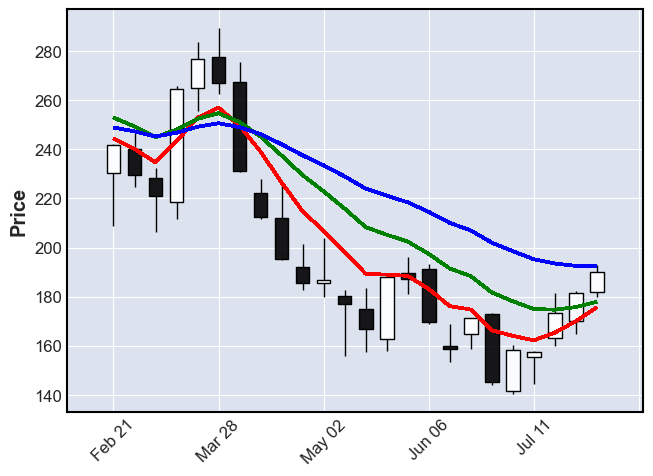

In [6]:
import mplfinance as mpf

selected_df = trading_formation.reset_index()
#print(selected_df)

#Get EMAs
dates = selected_df['Date']

#Get EMAs
dates = selected_df['Date']
ema6 = selected_df['EMA6']
ema12 = selected_df['EMA12']
ema24 = selected_df['EMA24']

datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]

#Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Date'] = quotes['Date'].astype('datetime64')
quotes = quotes.set_index('Date')

try: 
    quotes = quotes.drop('index',axis=1)
except:
    pass
  
#Plot
quotes = quotes.iloc[:,:8]
quotes
quotes.columns=['open','high','low','close','ema6','ema12','ema24']
quotes
#Plot Chart
mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b']))